In [47]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [48]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [49]:
fc = all_pitches[all_pitches['TaggedPitchType']=='Cutter']
print(fc.shape)

(8203, 167)


In [50]:
fc['whiff'] = np.where(fc['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_10996\1525590373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc['whiff'] = np.where(fc['PitchCall']=='StrikeSwinging',1,0)


In [51]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [52]:
fc_X = fc[preds]
fc_y = fc['whiff']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(fc_X, fc_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.71%


ROC AUC: 0.5126


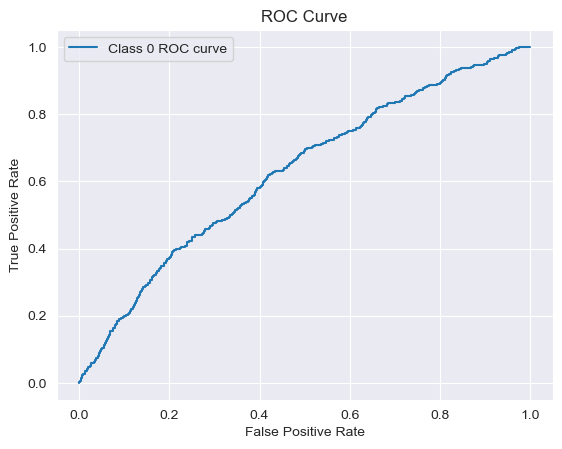

In [54]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [58]:
aub_fc = fc[fc['PitcherTeam']=='AUB_TIG']

In [64]:
# Get unique values
unique_values = fc['Pitcher'].unique()
aub_unique_values = aub_fc['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc[fc['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc[fc['Pitcher'] == value] for value in aub_unique_values}

['Carlson, Parker' 'Allsup, Chase' 'Isbell, Chase' 'Vail, Tommy'
 'McBride, Connor' 'Murphy, Hayden' 'Schorr, Ben']


In [66]:
def aub_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} cutter stuff+: {np.mean(stuff * 100)}")

In [67]:
for player in aub_unique_values:
    aub_fc_stuff(player)

Carlson, Parker cutter stuff+: 58.98899459838867
Allsup, Chase cutter stuff+: 76.94023895263672
Isbell, Chase cutter stuff+: 143.5036163330078
Vail, Tommy cutter stuff+: 32.28517150878906
McBride, Connor cutter stuff+: 108.11065673828125
Murphy, Hayden cutter stuff+: 15.714156150817871
Schorr, Ben cutter stuff+: 17.192230224609375


Splits 

In [12]:
fc_rr = fc[(fc['PitcherThrows'] == 'Right') & (fc['BatterSide'] == 'Right')]
fc_rl = fc[(fc['PitcherThrows'] == 'Right') & (fc['BatterSide'] == 'Left')]
fc_lr = fc[(fc['PitcherThrows'] == 'Left') & (fc['BatterSide'] == 'Right')]
fc_ll = fc[(fc['PitcherThrows'] == 'Left') & (fc['BatterSide'] == 'Left')]

print(fc_rr.shape)
print(fc_rl.shape)
print(fc_lr.shape)
print(fc_ll.shape)

(4522, 168)
(1976, 168)
(885, 168)
(805, 168)


In [13]:
fc_rr['whiff'] = np.where(fc_rr['PitchCall']=='StrikeSwinging',1,0)
fc_rl['whiff'] = np.where(fc_rl['PitchCall']=='StrikeSwinging',1,0)
fc_lr['whiff'] = np.where(fc_lr['PitchCall']=='StrikeSwinging',1,0)
fc_ll['whiff'] = np.where(fc_ll['PitchCall']=='StrikeSwinging',1,0)

C:\Users\charl\AppData\Local\Temp\ipykernel_10996\2437321745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_rr['whiff'] = np.where(fc_rr['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10996\2437321745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fc_rl['whiff'] = np.where(fc_rl['PitchCall']=='StrikeSwinging',1,0)
C:\Users\charl\AppData\Local\Temp\ipykernel_10996\2437321745.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [14]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [15]:
fc_rr_X = fc_rr[preds]
fc_rr_y = fc_rr['whiff']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(fc_rr_X, fc_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.52%


In [17]:
aub_fc_rr = fc_rr[fc_rr['PitcherTeam']=='AUB_TIG']
print(aub_fc_rr.shape)

(99, 168)


In [18]:
# Get unique values
unique_values = fc_rr['Pitcher'].unique()
aub_unique_values = aub_fc_rr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_rr[fc_rr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_rr[fc_rr['Pitcher'] == value] for value in aub_unique_values}

['Carlson, Parker' 'Allsup, Chase' 'Isbell, Chase' 'McBride, Connor'
 'Murphy, Hayden']


In [22]:
def aub_rr_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} RR Cutter stuff+: {np.mean(stuff * 100)}")

In [23]:
for pitcher in aub_unique_values:
    aub_rr_fc_stuff(pitcher)

Carlson, Parker RR Cutter stuff+: 31.0511474609375
Allsup, Chase RR Cutter stuff+: 75.36477661132812
Isbell, Chase RR Cutter stuff+: 52.612579345703125
McBride, Connor RR Cutter stuff+: 127.9946060180664
Murphy, Hayden RR Cutter stuff+: 5.887296676635742


In [24]:
fc_rl_X = fc_rl[preds]
fc_rl_y = fc_rl['whiff']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(fc_rl_X, fc_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.23%


In [26]:
aub_fc_rl = fc_rl[fc_rl['PitcherTeam']=='AUB_TIG']
print(aub_fc_rl.shape)

(77, 168)


In [27]:
# Get unique values
unique_values = fc_rl['Pitcher'].unique()
aub_unique_values = aub_fc_rl['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_rl[fc_rl['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_rl[fc_rl['Pitcher'] == value] for value in aub_unique_values}

['Carlson, Parker' 'Isbell, Chase' 'Allsup, Chase' 'McBride, Connor'
 'Murphy, Hayden' 'Schorr, Ben']


In [28]:
def aub_rl_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} RL Cutter stuff+: {np.mean(stuff * 100)}")

In [29]:
for pitcher in aub_unique_values:
    aub_rl_fc_stuff(pitcher)

Carlson, Parker RL Cutter stuff+: 112.88485717773438
Isbell, Chase RL Cutter stuff+: 55.63394546508789
Allsup, Chase RL Cutter stuff+: 88.19487762451172
McBride, Connor RL Cutter stuff+: 62.88816452026367
Murphy, Hayden RL Cutter stuff+: 13.73134994506836
Schorr, Ben RL Cutter stuff+: 13.1558837890625


In [30]:
fc_lr_X = fc_lr[preds]
fc_lr_y = fc_lr['whiff']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(fc_lr_X, fc_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.76%


In [32]:
aub_fc_lr = fc_lr[fc_lr['PitcherTeam']=='AUB_TIG']
print(aub_fc_lr.shape)

(5, 168)


In [33]:
# Get unique values
unique_values = fc_lr['Pitcher'].unique()
aub_unique_values = aub_fc_lr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_lr[fc_lr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_lr[fc_lr['Pitcher'] == value] for value in aub_unique_values}

['Vail, Tommy']


In [36]:
def aub_lr_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} LR Cutter stuff+: {np.mean(stuff * 100)}")

In [37]:
for pitcher in aub_unique_values:
    aub_lr_fc_stuff(pitcher)

Vail, Tommy LR Cutter stuff+: 193.25222778320312


In [38]:
fc_ll_X = fc_ll[preds]
fc_ll_y = fc_ll['whiff']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(fc_ll_X, fc_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.33%


In [40]:
aub_fc_ll = fc_ll[fc_ll['PitcherTeam']=='AUB_TIG']
print(aub_fc_ll.shape)

(4, 168)


In [41]:
# Get unique values
unique_values = fc_ll['Pitcher'].unique()
aub_unique_values = aub_fc_ll['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: fc_ll[fc_ll['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: fc_ll[fc_ll['Pitcher'] == value] for value in aub_unique_values}

['Vail, Tommy']


In [44]:
def aub_ll_fc_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(fc_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} LL Cutter stuff+: {np.mean(stuff * 100)}")

In [45]:
for pitcher in aub_unique_values:
    aub_ll_fc_stuff(pitcher)

Vail, Tommy LL Cutter stuff+: 5.027721405029297


In [46]:
aub_subsets['Vail, Tommy']

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff
122604,27,2023-05-12,20:05:46.26,3.0,2.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Gonzalez, Jacob",...,NaN,High,High,High,High,Low,NaN,NaN,NaN,0
122632,55,2023-05-12,20:21:25.06,2.0,1.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Harris, Calvin",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
122638,61,2023-05-12,20:23:28.98,2.0,7.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Harris, Calvin",...,NaN,High,High,High,Low,Low,NaN,NaN,NaN,0
122751,174,2023-05-12,21:26:04.97,3.0,1.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Kramer, John",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
